# GITHUB LINK: https://github.com/msarmad2000/multi-head-attention-transformer-tutorial-24089891

# Multi-Head Attention in Transformers: Code Notebook



In [61]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

# Always show plots
%matplotlib inline

# Make an "images" directory to store exported figures
os.makedirs("images", exist_ok=True)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cpu


# Medium Dataset
For the “medium” setting I use a slightly harder synthetic dataset. Each example is a sequence of 20 tokens, where each token is an integer between 0 and 19. There are 10,000 training sequences in total. Instead of just copying the input, the model has to predict a shifted version of the sequence: every output token should be the previous input token (circularly). This makes the task more interesting, because the model has to use positional information and learn how tokens relate across time, not just memorise individual values.




In [62]:
SEQ_LEN = 20
VOCAB_SIZE = 20
BATCH_SIZE = 64

def generate_shift_sequences(num_samples, seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE):
    """
    Generate (X, y) pairs for the shifted-copy task.

    X: random integer sequences of shape (num_samples, seq_len)
    y[i] = X[i-1] (circular shift to the right)
    """
    X = np.random.randint(0, vocab_size, size=(num_samples, seq_len))
    Y = np.roll(X, shift=1, axis=1)   # circular shift: previous token
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return X, Y

def create_dataloaders(num_train=10000, num_val=2000, num_test=2000,
                       seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE):
    X_train, y_train = generate_shift_sequences(num_train, seq_len, vocab_size)
    X_val,   y_val   = generate_shift_sequences(num_val, seq_len, vocab_size)
    X_test,  y_test  = generate_shift_sequences(num_test, seq_len, vocab_size)

    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val,   y_val)
    test_ds  = TensorDataset(X_test,  y_test)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_dataloaders()
print("Harder shifted-copy dataset ready.")


Harder shifted-copy dataset ready.


# Transformer Architecture

# Positional Encoding

In [63]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


# Multi-Head Attention Wrapper

In [64]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim, heads, batch_first=True)

    def forward(self, x):
        out, attn = self.mha(x, x, x, need_weights=True, average_attn_weights=False)
        return out, attn   # attn: (batch, heads, L, L)

# Transformer Encoder Block (with/without positional encoding)

In [65]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                 vocab=VOCAB_SIZE,
                 embed_dim=64,
                 heads=4,
                 ff=128,
                 seq_len=SEQ_LEN,
                 use_positional_encoding=True):
        super().__init__()

        self.embed = nn.Embedding(vocab, embed_dim)
        self.use_pe = use_positional_encoding

        if use_positional_encoding:
            self.pos = PositionalEncoding(embed_dim, max_len=5000)
        else:
            self.pos = nn.Identity()

        self.attn = MultiHeadSelfAttention(embed_dim, heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff),
            nn.ReLU(),
            nn.Linear(ff, embed_dim)
        )

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim, vocab)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos(x)

        attn_out, attn_weights = self.attn(x)
        x = self.norm1(x + attn_out)

        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)

        return self.out(x), attn_weights


# Training & Evaluation Utilities

In [66]:
def seq_accuracy(logits, y):
    preds = logits.argmax(-1)
    return (preds == y).all(1).float().mean().item()

def train_epoch(model, loader, opt, loss_fn):
    model.train()
    total_loss, total_acc, steps = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits, _ = model(x)
        loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), y.reshape(-1))
        loss.backward()
        opt.step()

        total_loss += loss.item()
        total_acc += seq_accuracy(logits, y)
        steps += 1

    return total_loss / steps, total_acc / steps

@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss, total_acc, steps = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits, _ = model(x)
        loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), y.reshape(-1))

        total_loss += loss.item()
        total_acc += seq_accuracy(logits, y)
        steps += 1

    return total_loss / steps, total_acc / steps


# Standard Training Function

In [67]:
def run_model(heads=4, epochs=8, seq_len=SEQ_LEN, use_pe=True):
    print(f"\nTraining model: heads={heads}, use_PE={use_pe}, seq_len={seq_len}")

    model = TransformerEncoder(
        heads=heads,
        seq_len=seq_len,
        use_positional_encoding=use_pe
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for ep in range(1, epochs + 1):
        tl, ta = train_epoch(model, train_loader, opt, loss_fn)
        vl, va = evaluate(model, val_loader, loss_fn)
        history["train_loss"].append(tl)
        history["train_acc"].append(ta)
        history["val_loss"].append(vl)
        history["val_acc"].append(va)

        print(f"Epoch {ep}: Train Acc={ta:.3f}  Val Acc={va:.3f}")

    return model, history


# Experiment 1 — More Heads (1, 2, 4, 8)

In [68]:
results_heads = {}
for h in [1, 2, 4, 8]:
    model, hist = run_model(heads=h, epochs=8)
    results_heads[h] = {"model": model, "hist": hist}


Training model: heads=1, use_PE=True, seq_len=20
Epoch 1: Train Acc=0.008  Val Acc=0.199
Epoch 2: Train Acc=0.896  Val Acc=0.998
Epoch 3: Train Acc=1.000  Val Acc=1.000
Epoch 4: Train Acc=1.000  Val Acc=1.000
Epoch 5: Train Acc=1.000  Val Acc=1.000
Epoch 6: Train Acc=1.000  Val Acc=1.000
Epoch 7: Train Acc=1.000  Val Acc=1.000
Epoch 8: Train Acc=1.000  Val Acc=1.000

Training model: heads=2, use_PE=True, seq_len=20
Epoch 1: Train Acc=0.000  Val Acc=0.003
Epoch 2: Train Acc=0.646  Val Acc=0.954
Epoch 3: Train Acc=0.981  Val Acc=0.994
Epoch 4: Train Acc=0.997  Val Acc=0.999
Epoch 5: Train Acc=0.999  Val Acc=1.000
Epoch 6: Train Acc=1.000  Val Acc=1.000
Epoch 7: Train Acc=1.000  Val Acc=1.000
Epoch 8: Train Acc=1.000  Val Acc=1.000

Training model: heads=4, use_PE=True, seq_len=20
Epoch 1: Train Acc=0.000  Val Acc=0.000
Epoch 2: Train Acc=0.255  Val Acc=0.732
Epoch 3: Train Acc=0.874  Val Acc=0.959
Epoch 4: Train Acc=0.980  Val Acc=0.991
Epoch 5: Train Acc=0.996  Val Acc=0.994
Epoch 6: T

# Plot comparison

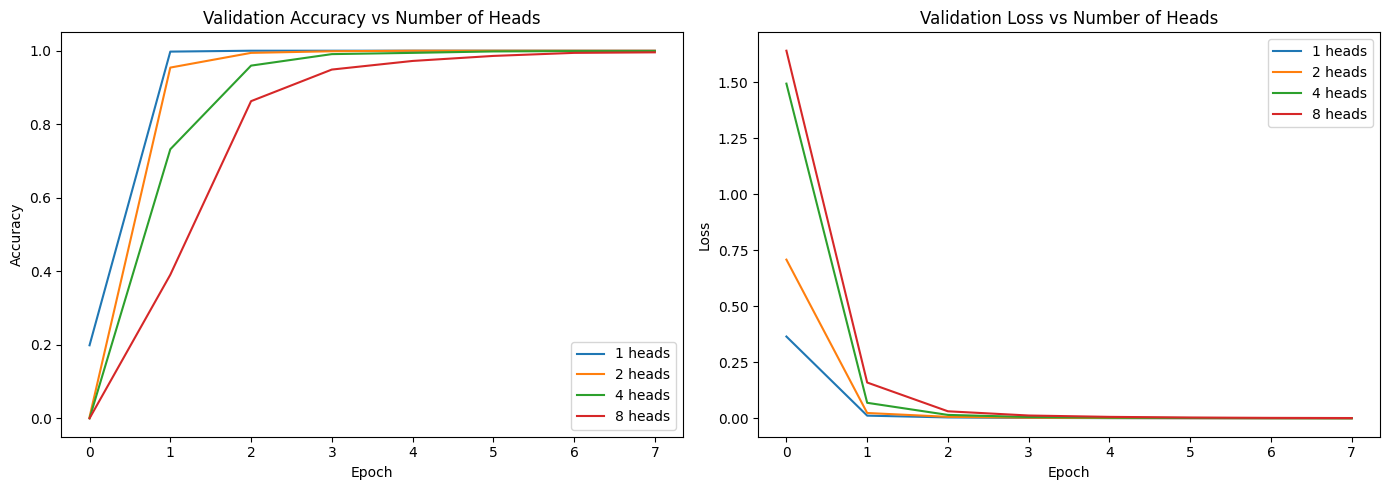

In [69]:
def plot_head_comparison(results):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for h, res in results.items():
        plt.plot(res["hist"]["val_acc"], label=f"{h} heads")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title("Validation Accuracy vs Number of Heads")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for h, res in results.items():
        plt.plot(res["hist"]["val_loss"], label=f"{h} heads")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Validation Loss vs Number of Heads")
    plt.legend()

    plt.tight_layout()
    plt.savefig("images/head_comparison.png")
    plt.show()

plot_head_comparison(results_heads)


# Experiment 2 — Positional Encoding Ablation

# Train both variants

In [70]:
model_pe, hist_pe = run_model(heads=4, use_pe=True, epochs=8)
model_nope, hist_nope = run_model(heads=4, use_pe=False, epochs=8)

results_pe = {
    "with_PE": hist_pe,
    "without_PE": hist_nope
}



Training model: heads=4, use_PE=True, seq_len=20
Epoch 1: Train Acc=0.000  Val Acc=0.000
Epoch 2: Train Acc=0.219  Val Acc=0.652
Epoch 3: Train Acc=0.835  Val Acc=0.937
Epoch 4: Train Acc=0.967  Val Acc=0.981
Epoch 5: Train Acc=0.992  Val Acc=0.991
Epoch 6: Train Acc=0.998  Val Acc=0.996
Epoch 7: Train Acc=0.999  Val Acc=0.998
Epoch 8: Train Acc=1.000  Val Acc=0.999

Training model: heads=4, use_PE=False, seq_len=20
Epoch 1: Train Acc=0.000  Val Acc=0.000
Epoch 2: Train Acc=0.000  Val Acc=0.000
Epoch 3: Train Acc=0.000  Val Acc=0.000
Epoch 4: Train Acc=0.000  Val Acc=0.000
Epoch 5: Train Acc=0.000  Val Acc=0.000
Epoch 6: Train Acc=0.000  Val Acc=0.000
Epoch 7: Train Acc=0.000  Val Acc=0.000
Epoch 8: Train Acc=0.000  Val Acc=0.000


# Plot

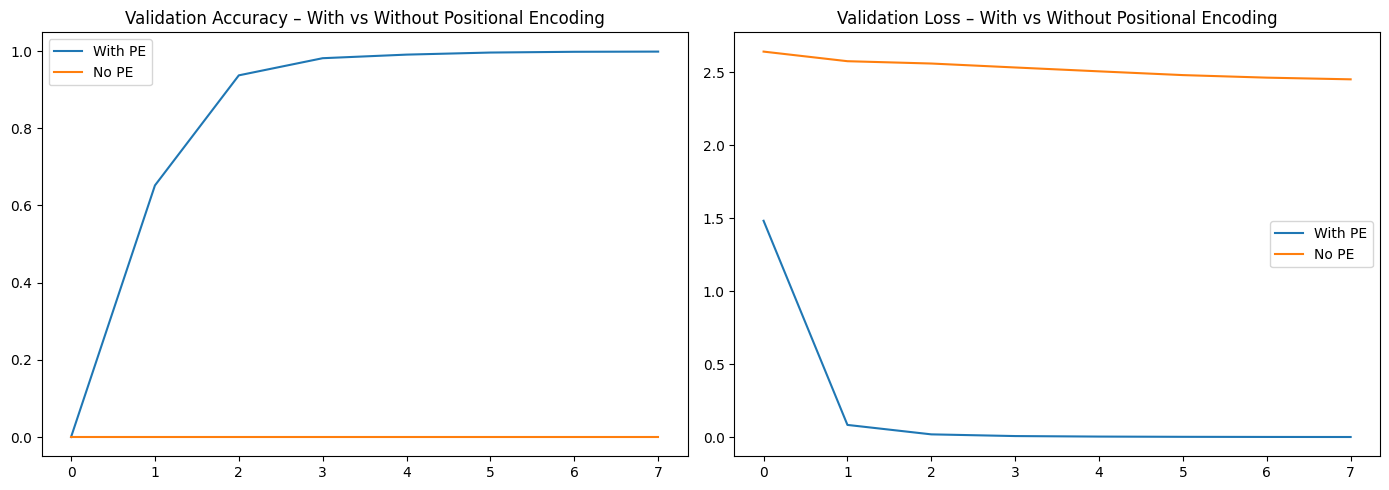

In [71]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(hist_pe["val_acc"], label="With PE")
plt.plot(hist_nope["val_acc"], label="No PE")
plt.title("Validation Accuracy – With vs Without Positional Encoding")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_pe["val_loss"], label="With PE")
plt.plot(hist_nope["val_loss"], label="No PE")
plt.title("Validation Loss – With vs Without Positional Encoding")
plt.legend()

plt.tight_layout()
plt.savefig("images/positional_encoding_ablation.png")
plt.show()


# Experiment 3 — Different Sequence Lengths (10, 20, 40)

# Helper to build loaders for any seq_len

In [72]:
def create_loaders_seq_len(seq_len,
                           num_train=6000,
                           num_val=1000,
                           num_test=1000,
                           vocab_size=VOCAB_SIZE):
    """
    Create loaders for the shifted-copy task with a given sequence length.
    """
    def gen(n):
        X = np.random.randint(0, vocab_size, size=(n, seq_len))
        Y = np.roll(X, shift=1, axis=1)  # shifted targets
        return (torch.tensor(X, dtype=torch.long),
                torch.tensor(Y, dtype=torch.long))

    Xtr, Ytr = gen(num_train)
    Xva, Yva = gen(num_val)
    Xte, Yte = gen(num_test)

    train_ds = TensorDataset(Xtr, Ytr)
    val_ds   = TensorDataset(Xva, Yva)
    test_ds  = TensorDataset(Xte, Yte)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)
    return train_loader, val_loader, test_loader


# Run experiment

In [73]:
seq_results = {}
for sl in [10, 20, 40]:
    print(f"\n=== Sequence Length {sl} ===")
    train_loader_sl, val_loader_sl, test_loader_sl = create_loaders_seq_len(sl)

    model_sl = TransformerEncoder(
        vocab=VOCAB_SIZE,
        embed_dim=64,
        heads=4,
        ff=128,
        seq_len=sl,
        use_positional_encoding=True,
    ).to(device)

    opt = torch.optim.Adam(model_sl.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for ep in range(1, 7):
        tl, ta = train_epoch(model_sl, train_loader_sl, opt, loss_fn)
        vl, va = evaluate(model_sl, val_loader_sl, loss_fn)
        hist["train_loss"].append(tl)
        hist["train_acc"].append(ta)
        hist["val_loss"].append(vl)
        hist["val_acc"].append(va)
        print(f"Epoch {ep}: Train Acc={ta:.4f}, Val Acc={va:.4f}")

    seq_results[sl] = {
        "model": model_sl,
        "hist": hist,
        "test_loader": test_loader_sl,
    }



=== Sequence Length 10 ===
Epoch 1: Train Acc=0.0000, Val Acc=0.0000
Epoch 2: Train Acc=0.2940, Val Acc=0.8605
Epoch 3: Train Acc=0.9498, Val Acc=0.9785
Epoch 4: Train Acc=0.9968, Val Acc=0.9902
Epoch 5: Train Acc=0.9995, Val Acc=0.9971
Epoch 6: Train Acc=0.9998, Val Acc=0.9980

=== Sequence Length 20 ===
Epoch 1: Train Acc=0.0000, Val Acc=0.0000
Epoch 2: Train Acc=0.0012, Val Acc=0.0182
Epoch 3: Train Acc=0.4002, Val Acc=0.7102
Epoch 4: Train Acc=0.8711, Val Acc=0.9264
Epoch 5: Train Acc=0.9734, Val Acc=0.9768
Epoch 6: Train Acc=0.9927, Val Acc=0.9941

=== Sequence Length 40 ===
Epoch 1: Train Acc=0.0000, Val Acc=0.0000
Epoch 2: Train Acc=0.0000, Val Acc=0.0000
Epoch 3: Train Acc=0.0003, Val Acc=0.0035
Epoch 4: Train Acc=0.1519, Val Acc=0.3953
Epoch 5: Train Acc=0.6393, Val Acc=0.7605
Epoch 6: Train Acc=0.8697, Val Acc=0.8938


# Plot comparison

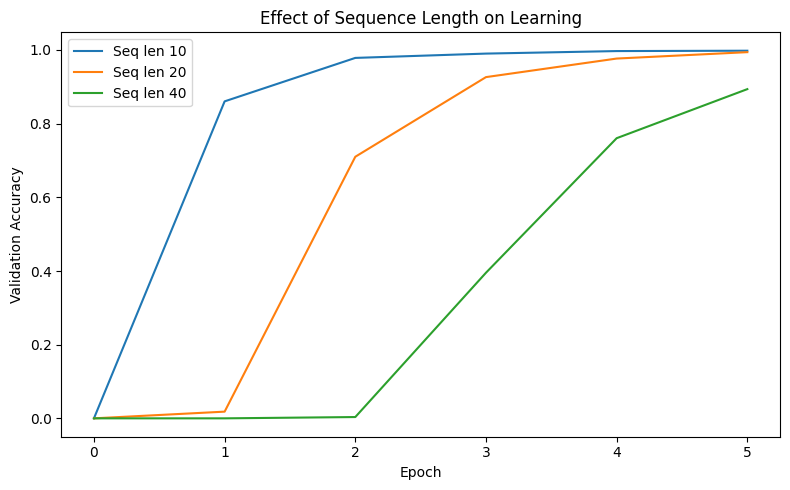

In [74]:
plt.figure(figsize=(8,5))
for sl, res in seq_results.items():
    plt.plot(res["hist"]["val_acc"], label=f"Seq len {sl}")
plt.legend()
plt.xlabel("Epoch"); plt.ylabel("Validation Accuracy")
plt.title("Effect of Sequence Length on Learning")
plt.tight_layout()
plt.savefig("images/sequence_length_comparison.png")
plt.show()


# Attention Visualisation Utilities

x_sample shape: torch.Size([64, 20])
attn shape: torch.Size([64, 4, 20, 20])


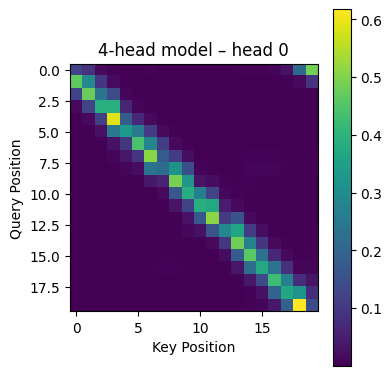

In [75]:
# Make sure plots display
%matplotlib inline

def get_sample_batch(loader):
    for x, y in loader:
        return x.to(device), y.to(device)

def plot_attention_matrix(attn, head, sample=0, title=""):
    matrix = attn[sample, head].detach().cpu().numpy()
    plt.figure(figsize=(4,4))
    plt.imshow(matrix, cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.tight_layout()
    plt.show()

x_sample, y_sample = get_sample_batch(test_loader)
print("x_sample shape:", x_sample.shape)

model_4 = results_heads[4]["model"].to(device)
model_4.eval()

with torch.no_grad():
    logits, attn = model_4(x_sample)

print("attn shape:", attn.shape)

# 3. Plot attention for head 0
plot_attention_matrix(attn, head=0, sample=0, title="4-head model – head 0")


# Visualise Attention for Any Model

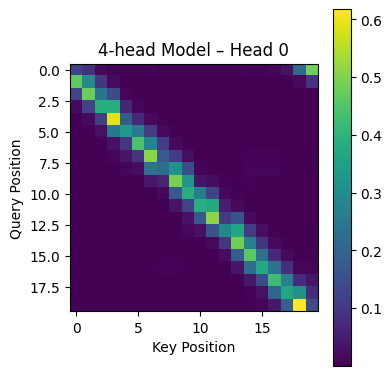

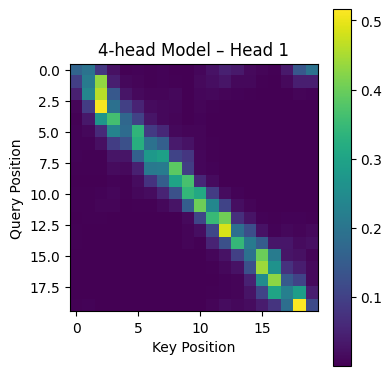

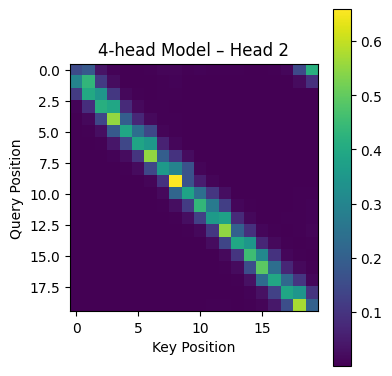

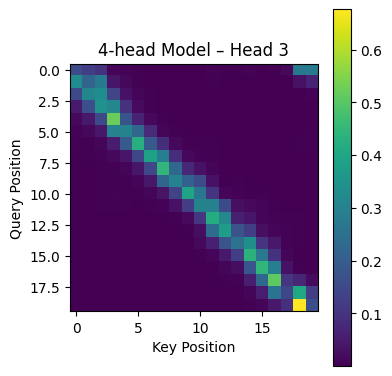

In [76]:
x_sample, _ = get_sample_batch(test_loader)

model_4 = results_heads[4]["model"]
model_4.eval()

with torch.no_grad():
    _, attn = model_4(x_sample)

for h in range(4):
    plot_attention_matrix(attn, h, title=f"4-head Model – Head {h}")
